In [ ]:
# !pip3 install crowelab_pyir
# !pip3 install scikit-learn
# !pip install seaborn
# !pip install MDAnalysis
# !pip install pandas
# !pip install BioPython
# !pip install matplotlib
# !echo 'y' | conda install conda-forge::pdbfixer
# !pip install pyrosettacolabsetup
# import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
# import pyrosetta; pyrosetta.init()
# !pip install pyrosetta

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   -------- ------------------------------- 61.4/294.9 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 6.1 MB/s eta 0:00:00


In [4]:
# import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
# import pyrosetta; pyrosetta.init()

ModuleNotFoundError: No module named 'google'

In [74]:
#In this notebook, we will write the code and functions to extract the features from the pdb files that are generated from AlphaFold2
from pathlib import Path
import os
import sys
import time
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align, gnm
from MDAnalysis.analysis.distances import dist, distance_array
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from Bio.PDB import PDBList, PDBParser, Structure, Model, Chain, Residue, Atom
from Bio.PDB.kdtrees import KDTree
from Bio.PDB import PDBIO
from Bio.SeqUtils import seq1

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# from crowelab_pyir import PyIR
os.chdir('d:/Lab/TCRbinding/')

In [ ]:
codon_table = {
    'A': ['GCA', 'GCC', 'GCG', 'GCT'],
    'R': ['AGA', 'AGG', 'CGA', 'CGC', 'CGG', 'CGT'],
    # ... add all 20 amino acids and stop codons ('*')
    'M': ['ATG'],
    '*': ['TAA', 'TAG', 'TGA']
}

def reverse_translate(protein_seq):
    """Generates possible DNA sequences for a protein sequence."""
    aa_list = [codon_table[aa.upper()] for aa in protein_seq if aa.upper() in codon_table]
    # Use itertools.product to get all combinations of codons
    all_dna_combinations = itertools.product(*aa_list)
    dna_sequences = [''.join(codons) for codons in all_dna_combinations]
    return dna_sequences

In [ ]:
#What we need to do in this script:
# - Get regions from sequence (with pyir)
# - Read in a pdb file
# - Generate contact map
# - Get distance from regions Center of Mass
# - Get the number of H-bonds between regions (would require adding back hydrogens)
# - Calculate buried surface area
# - Calculate energy terms (no relaxation, requires pyrosetta)

In [25]:
#Write a function that reads in the pdf file and runs all the functions to get a feature map
def extractFeatures(name,pdb,seqFile):
    pdb = PDBParser(QUIET=True).get_structure('structure', pdb)

    #Get regions from sequence

    pyirfiltered = PyIR(query=seqFile, args=['--outfmt', 'tsv','--sequence_type', 'prot','--legacy','-s', 'human'])#, '--enable_filter'])
    result = pyirfiltered.run()
    print(result) 
    
    #Get contact map
    contactFile = f"./Contact/{name}.csv"
    contactMap = getContactMap(pdb)
    # df = pd.DataFrame(contactMap)
    # df.to_csv(contactFile, index=False) #We will have to pad this to the 1024x1024 size to fit into the model

    #Get distances from centers of mass of regions

def getContactMap(structure):
    residues = [r for r in structure.get_residues() if r.get_id()[0] == " "]
    distances = np.empty([len(residues),len(residues)])
    for x in range(len(residues)):
        for y in range(len(residues)):
          try: 
            one  = residues[x]["CA"].get_coord()
            two = residues[y]["CA"].get_coord()
            # distances[(x * len(residues)) + y] = np.linalg.norm(one-two)
            distances[x,y] = np.linalg.norm(one-two)
          except:
            # print("No alpha carbon, distance nan")
            #  distances[(x * len(residues)) + y] = np.nan
            distances[x,y] = np.nan

    return distances

def getDistanceCOM(region1, region2):
    pass

def getHbonds(region1, region2):
    pass




In [26]:
extractFeatures("Pos_29","./Pos_29.pdb","./pos_29.fasta")

Splitting input fasta file ./pos_29.fasta
1 sequences successfully split into 1 pieces
Starting process pool using 32 processors


  0%|                                                                                            | 0/1 [00:00<?, ?seq/s]


NotImplementedError: TSV outputting unsupported with legacy output; use non-legacy mode

In [60]:
#Now that we have the features extracted we can load them in and train a model (doesn't really matter why not a linear model)
print(os.getcwd())
ground = pd.read_csv('./ModelData/KnownStructures/ColabFold/features.csv', index_col=0)
ground['Source'] = ['Ground'] * len(ground)
ground_labels = [1] * len(ground)
exp = pd.read_csv('./ModelData/PredictedInteractions/ColabFold/features.csv', index_col=0)
exp['Source'] = ['Exp'] * len(exp)
exp_labels = exp['Name'].apply(lambda x: 1 if 'Pos' in x else 0)
fake = pd.read_csv('./ModelData/Fake/ColabFold/features.csv', index_col=0)
fake['Source'] = ['Fake'] * len(fake)
fake_labels = [0] * len(fake)
immpred = pd.read_csv('./ModelData/Immpred/ColabFold/features.csv', index_col=0)
immpred['Source'] = ['Immpred'] * len(immpred)
print(immpred['Name'])
#We also have to read in the immpred labels because we need to know which ones are positive and which are negative
immpred_labels = pd.read_csv('./Downloaded/immrep23/immpred.csv', index_col=0).loc[immpred['Name']]['Label'].to_numpy()
print(immpred_labels)
#Now combine them into one dataframe
# data = pd.concat([ground, exp, fake, immpred], axis=0)
# data['Label'] = np.concatenate([ground_labels, exp_labels, fake_labels, immpred_labels])
data = pd.concat([ground, exp, fake], axis=0)
data['Label'] = np.concatenate([ground_labels, exp_labels, fake_labels])
print(data)
print(data.columns)
print(np.concatenate([np.array(data.columns)[:-2][:21],np.array(data.columns)[:-2][24:]]))

d:\Lab\TCRbinding
0          Test_1
1         Test_10
2        Test_100
3       Test_1000
4       Test_1001
          ...    
1017     Test_995
1018     Test_996
1019     Test_997
1020     Test_998
1021     Test_999
Name: Name, Length: 1022, dtype: object
[0 0 0 ... 0 0 0]
        Total_SSA      pMHC_SSA       TCR_SSA          BSA  cdr3a_pep_dist  \
0    18214.102469   9884.181097  10358.421108  2028.499736       10.166747   
1    18159.479724  10019.862412  10488.605302  2348.987991       10.017340   
2    19165.866273  10688.670832  10601.911152  2124.715711        9.390415   
3    19301.058279  10149.532089  11062.820996  1911.294805       13.654529   
4    19039.026355  10692.914056  10548.751496  2202.639197       12.610772   
..            ...           ...           ...          ...             ...   
595  30541.558632  10021.191155  22141.898087  1621.530610       11.257868   
596  46563.078306  10225.740743  38261.508086  1924.170522       28.516435   
597  29884.078003   9941

In [ ]:
#Check to see rows which contain NaN values
print(data[data.isna().any(axis=1)])
#apparently only 26 rows have NaN values, so we can just drop them
data = data.dropna()
print(data)


Empty DataFrame
Columns: [Total_SSA, pMHC_SSA, TCR_SSA, BSA, cdr3a_pep_dist, cdr3b_pep_dist, cdr2a_mhcb_dist, cdr2b_mhca_dist, cdr1a_mhcb_dist, cdr1b_mhca_dist, cdr3a_pep_angle, cdr3b_pep_angle, cdr3a_pep_hbonds, cdr3b_pep_hbonds, cdr2a_mhcb_hbonds, cdr2b_mhca_hbonds, cdr1a_mhcb_hbonds, cdr1b_mhca_hbonds, pep_mhca_hbonds, pep_mhcb_hbonds, cdr3a_cdr3b_hbonds, Name, MHCB, Peptide, Gcom, Gcom_relaxed, Gtcr, Gtcr_relaxed, Gpep, Gpep_relaxed, Gmhc, Gmhc_relaxed, Gpmhc, Gpmhc_relaxed, Gtcrmhc, Gtcrmhc_relaxed, Gbind1, Gbind2, Source, Label]
Index: []

[0 rows x 40 columns]
        Total_SSA      pMHC_SSA       TCR_SSA          BSA  cdr3a_pep_dist  \
0    18214.102469   9884.181097  10358.421108  2028.499736       10.166747   
1    18159.479724  10019.862412  10488.605302  2348.987991       10.017340   
2    19165.866273  10688.670832  10601.911152  2124.715711        9.390415   
3    19301.058279  10149.532089  11062.820996  1911.294805       13.654529   
4    19039.026355  10692.914056  105

[1.98824406e-01 1.24354897e-01 9.34774285e-02 6.90596302e-02
 5.49067764e-02 4.12467271e-02 3.74735533e-02 3.53442248e-02
 3.22702825e-02 3.09887531e-02 2.95147094e-02 2.79796043e-02
 2.66851915e-02 2.58542098e-02 2.38160081e-02 2.34139454e-02
 2.21474483e-02 1.98480213e-02 1.93674840e-02 1.67510489e-02
 1.35532848e-02 1.17226161e-02 6.49802086e-03 5.34557347e-03
 4.12390377e-03 2.57683375e-03 1.36884512e-03 5.15512016e-04
 4.20936213e-04 3.45764619e-04 1.49193399e-04 5.51666286e-05
 2.16528285e-17 0.00000000e+00 0.00000000e+00]
           PC1       PC2  Source  Label
0     0.519422 -1.477877  Ground      1
1    -0.119037 -2.114619  Ground      1
2     0.703315 -2.753858  Ground      1
3    -0.079720 -1.348712  Ground      1
4     1.540285 -2.750331  Ground      1
...        ...       ...     ...    ...
1402 -1.042465  2.125314    Fake      0
1403  2.347503  6.979534    Fake      0
1404 -1.825797  0.023414    Fake      0
1405 -1.571391  1.835410    Fake      0
1406  0.070148 -1.269911 

(-5.0, 20.0)

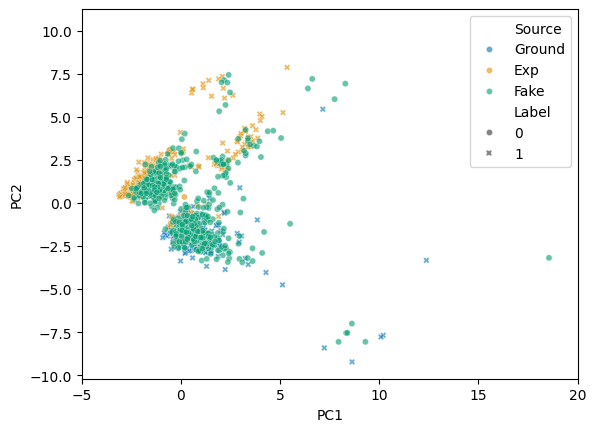

In [82]:
#Now we explore the data by plotting the principle components

# Separating out the features
features = np.concatenate([np.array(data.columns)[:-2][:21],np.array(data.columns)[:-2][24:]])
x = data.loc[:, features].values
x = StandardScaler().fit_transform(x)
# Separating out the target
y = data.loc[:,['Source']].values

#Run PCA
pca = PCA()#n_components=2)
principalComponents = pca.fit_transform(x)
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents[:,:2] , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, pd.Series(data[['Source']].to_numpy().flatten(), name='Source'),pd.Series(data[['Label']].to_numpy().flatten(), name='Label')], axis = 1)
print(finalDf)
# Plot PCA
sns.set_palette("colorblind")
sns.scatterplot(x="PC1", y="PC2", hue="Source",style = 'Label',s = 20,alpha=0.6, data=finalDf)
plt.xlim(-5, 20) 

# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('PC1', fontsize = 15)
# ax.set_ylabel('PC2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# targets = ['Ground', 'Exp', 'Fake', 'Immpred']
# labels = ['1', '0']
# shapes = ['o', 'x']
# colors = ['r', 'g', 'b','y']
# for target, color, label, shape in zip(targets,colors,labels,shapes):
#     indicesToKeep = (finalDf['Source'] == target) & (finalDf['Label'] == label)
#     ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
#                , finalDf.loc[indicesToKeep, 'PC2']
#                , c = color
#                , marker= shape
#                , s = 50)
# ax.legend(targets)
# ax.grid()

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)


